1. Mount the google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


2. To implement Graph structure importing necessary packages

In [ ]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

1.12.1+cu113


In [ ]:
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html 
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

In [ ]:
!pip install -U -q PyDrive
!pip install -q git+https://github.com/snap-stanford/deepsnap.git

# **1. Datasets**

In [ ]:
import pandas as pd

In [ ]:
user_path='/content/drive/MyDrive/project/data/user.csv'
rating_path = '/content/drive/MyDrive/project/data/tourism_rating.csv'
place_path = '/content/drive/MyDrive/project/data/tourism_with_id.csv'

# merged1 = pd.merge(df_ratings, df_places, on='Place_Id', how='left')
# df_user=pd.read_csv('/content/drive/MyDrive/project/data/user.csv')
# review_path=pd.merge(merged1, df_user, on='User_Id', how='left')

IMport modules

In [ ]:
import random
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
import torch
from torch import nn, optim, Tensor

In [ ]:
import torch_geometric

In [ ]:
from torch_sparse import SparseTensor, matmul

In [ ]:
# packages for importing the GCN model

from torch_geometric.utils import structured_negative_sampling
from torch_geometric.data import download_url, extract_zip
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.typing import Adj

5. Load the dataset

In [ ]:
# load user and review nodes
def load_node_csv(path, index_col):
    """Loads csv containing node information

    Args:
        path (str): path to csv file
        index_col (str): column name of index column

    Returns:
        dict: mapping of csv row to node id
    """
    df = pd.read_csv(path, index_col=index_col)
    mapping = {index: i for i, index in enumerate(df.index.unique())}
    return mapping

# This method basically creates a dictionary containing index for unique user or business id.

In [ ]:
user_mapping = load_node_csv(user_path, index_col='User_Id')
place_mapping = load_node_csv(place_path, index_col='Place_Id')


In [ ]:
# Homogenous graph with no disticntion between users and business
# load edges between users and business
def load_edge_csv(path, src_index_col, src_mapping, dst_index_col,dst_mapping, link_index_col,rating_threshold):
    """Loads csv containing edges between users and items

    Args:
        path (str): path to csv file
        src_index_col (str): column name of users
        src_mapping (dict): mapping between row number and user id
        dst_index_col (str): column name of items
        dst_mapping (dict): mapping between row number and item id
        link_index_col (str): column name of user item interaction
        rating_threshold (int, optional): Threshold to determine positivity of edge. Defaults to 4.

    Returns:
        torch.Tensor: 2 by N matrix containing the node ids of N user-item edges
    """
    df = pd.read_csv(path)
    edge_index = None
    src = [src_mapping[index] for index in df[src_index_col]]
    # list comprehension
    # creates src list for users, dst list for items with index values
    dst = [dst_mapping[index] for index in df[dst_index_col]]
    
    edge_attr = torch.from_numpy(df[link_index_col].values).view(-1, 1).to(torch.long) >= rating_threshold
  # Assigns edge between the user and the item if the user has rated the place/business with rating >=4
    edge_index = [[],[]]
    for i in range(edge_attr.shape[0]):
        if edge_attr[i]:
            edge_index[0].append(src[i])
            edge_index[1].append(dst[i])
            
    # returns a tensor object of the indices which are yet to be converted to embeddings to be given to a model
    return torch.tensor(edge_index)

In [ ]:
edge_index = load_edge_csv(
    rating_path,
    src_index_col='User_Id',
    src_mapping=user_mapping,
    dst_index_col='Place_Id',
    dst_mapping=place_mapping,
    link_index_col='Place_Ratings',
    rating_threshold=4,
    # To preprocess the data to include ratings >=4 as we would like to recommend these businsess/places to users
)

In [ ]:
edge_index.shape

torch.Size([2, 10000])

7. Train/validation/test split

In [ ]:
# Representing the adjacency matrix as sparsetensor as the matrix has most values as zero
# This representation reduces memory head

num_users, num_places = len(user_mapping), len(place_mapping)

#shape of the edge_index ie., link between user and places nodes is flattened
num_interactions = edge_index.shape[1]

In [ ]:
print(num_users)
print(num_places)
print(num_interactions) # total no of edges

300
437
2021


In [ ]:
print(num_users)
print(num_places)
print(num_interactions) # total no of edges

300
437
10000


In [ ]:
#all_indicides hold all the index values for the graph_index in an array format 
all_indices = [i for i in range(num_interactions)]

# uses sklearn.model_selection.train_test_split package to split the 3 sets train, validation and test,
# but the underlying input graph remains the same

# of all the indices it splits the 20% to test_indices and its (complement) 80% to train_indicies
train_indices, test_indices = train_test_split(all_indices, test_size=0.1, random_state=1)

# of the test_indicies, it splits 10% to test_indicies and its (complement) 10% to val_indices
val_indices, test_indices = train_test_split(test_indices, test_size=0.5, random_state=1)

In [ ]:
# As we are doing link/edge prediction we are splitting this edge information to 3 sets train, validation and test
# proportion of edges are as follows 80% --> train; 10% --> test; 10% --> validation

# The [:, :] stands for everything from the beginning to the end just like for lists

# The below statement assigns the interaction edges which were generated for the homogenous graph to the appropriate proportion
# to that particular

# we take the edges (tuples between user and places ie., the link information) and split to test and train datasets

train_edge_index = edge_index[:, train_indices]
val_edge_index = edge_index[:, val_indices]
test_edge_index = edge_index[:, test_indices]

In [ ]:
# convert edge indices into Sparse Tensors: https://pytorch-geometric.readthedocs.io/en/latest/notes/sparse_tensor.html
# Here the edge_index format (interaction graph) is converted to sparsetensor (mainly used for matrices with more zero values)
# used for GNN models, this format is given as input to the models beneath.

# train_sparse_edge_index = SparseTensor(row=train_edge_index[0], col=train_edge_index[1], sparse_sizes=(
#     num_users + num_places, num_users + num_places))
# val_sparse_edge_index = SparseTensor(row=val_edge_index[0], col=val_edge_index[1], sparse_sizes=(
#     num_users + num_places, num_users + num_places))
# test_sparse_edge_index = SparseTensor(row=test_edge_index[0], col=test_edge_index[1], sparse_sizes=(
#     num_users + num_places, num_users + num_places))

In [ ]:
train_rowinput = torch.cat([train_edge_index[0], num_users + train_edge_index[1]])
train_colinput = torch.cat([num_users + train_edge_index[1], train_edge_index[1]])

val_rowinput = torch.cat([val_edge_index[0], num_users + val_edge_index[1]])
val_colinput = torch.cat([num_users + val_edge_index[1], val_edge_index[1]])

test_rowinput = torch.cat([test_edge_index[0], num_users + test_edge_index[1]])
test_colinput = torch.cat([num_users + test_edge_index[1], test_edge_index[1]])

train_sparse_edge_index = SparseTensor(row=train_rowinput, col=train_colinput, sparse_sizes=(
    num_users + num_places, num_users + num_places))
val_sparse_edge_index = SparseTensor(row=val_rowinput, col=val_colinput, sparse_sizes=(
    num_users + num_places, num_users + num_places))
test_sparse_edge_index = SparseTensor(row=test_rowinput, col=test_colinput, sparse_sizes=(
    num_users + num_places, num_users + num_places))

9. Mini Batch for postive, negative samples

In [ ]:
# function which random samples a mini-batch of positive and negative samples
def sample_mini_batch(batch_size, edge_index):
    """Randomly samples indices of a minibatch given an adjacency matrix

    Args:
        batch_size (int): minibatch size
        edge_index (torch.Tensor): 2 by N list of edges

    Returns:
        tuple: user indices, positive item indices, negative item indices
    """
    edges = structured_negative_sampling(edge_index)
    edges = torch.stack(edges, dim=0)
    indices = random.choices(
        [i for i in range(edges[0].shape[0])], k=batch_size)
    batch = edges[:, indices]
    user_indices, pos_item_indices, neg_item_indices = batch[0], batch[1], batch[2]
    return user_indices, pos_item_indices, neg_item_indices

8. Implementing LightGCN

In [ ]:
# defines LightGCN model

# The below model uses torch_geometric.nn package for defining the LightGCN model
# The model is from https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html

# packages used torch_geometric.nn.conv.gcn_conv for normalization, torch_geometric.nn.conv for MessagePassing

class LightGCN(MessagePassing):
    """LightGCN Model as proposed in https://arxiv.org/abs/2002.02126
    """
    
    # This _init_method lets the class initialize the objects (constructor)
    #Initializes the Light GCN model

    def __init__(self, num_users, num_places, embedding_dim=64, K=3, add_self_loops=False):
        """Initializes LightGCN Model

        Args:
            num_users (int): Number of users
            num_places (int): Number of places/business
            embedding_dim (int, optional): Dimensionality of embeddings. Defaults to 8.
            K (int, optional): Number of message passing layers. Defaults to 3.
            add_self_loops (bool, optional): Whether to add self loops for message passing. Defaults to False.
        """

        super().__init__()
        # refers to the parent class objects that were created above

        # The PyTorch module, nn.Embedding as seen below will assign each node an embedding vector 
        # such that we have an embedding matrix Z where each row is the d-dimensional embedding vector for a node in our graph

        self.num_users, self.num_places = num_users, num_places
        # assigns the users and places/business similar to the existing original paper code

        self.embedding_dim, self.K = embedding_dim, K
        # the embedding dimesion values and no of message passing layers are defined in the init method.

        self.add_self_loops = add_self_loops
        # Here there are no self loops as it is a bipartite graph.
        
        # calculating the base 64 embedding vectors for the user and places(items) (upto 8)
        # This 
        self.users_emb = nn.Embedding(
            num_embeddings=self.num_users, embedding_dim=self.embedding_dim) # e_u^0

        self.items_emb = nn.Embedding(
            num_embeddings=self.num_places, embedding_dim=self.embedding_dim) # e_i^0

        # parameter initilzation of the initial weights 
        # initalization of weights for the embedding matrix for user, place(business)


        # torch.nn.init.normal_(tensor, mean=0.0, std=1.0) -->Fills the input Tensor with values drawn from the normal distribution 
        # setting standard deviation = 0.1 instead of 1 (overriding the normal distribution which is 1 by setting standard deviation parameters)
        nn.init.normal_(self.users_emb.weight, std=0.1)
        # gaussian distribution(general distribution) mean =0, variance =1 (normal distribution)
        # setting parametes for neural network
        nn.init.normal_(self.items_emb.weight, std=0.1)

# Message passing and aggregation functions are mentioned below

    def forward(self, edge_index: SparseTensor):
        """Forward propagation of LightGCN Model.

        Args:
            edge_index (SparseTensor): adjacency matrix

        Returns:
            tuple (Tensor): e_u_k, e_u_0, e_i_k, e_i_0
        """
        # e_u_k(embeddings of the user at kth layer), e_u_0, e_i_k, e_i_0
        # compute \tilde{A}: symmetrically normalized adjacency matrix
        
        # The goal of normalization is to transform features to be on a similar scale. 
        # This improves the performance and training stability of the model
        edge_index_norm = gcn_norm(
            edge_index, add_self_loops=self.add_self_loops)
        
        # print("edge_index_norm is",edge_index_norm)

        # Concatenates the given sequence of seq tensors in the given dimension.
        # concatenates the weights  
        # [num_users*embedding_dim] size = self.users_emb.weight size

        #Combining for the final embedding
        emb_0 = torch.cat([self.users_emb.weight, self.items_emb.weight]) # E^0
        # print("emb_0:",emb_0)
        # ipdb.set_trace()
        # converting the item to python list, to increase the dimensions; to create a fake 1 dimension
        embs = [emb_0]
        # print("embs",embs)
        # (a model takes batch_size as 1st dimension, 1* dimension of item within the list --> size  )
        emb_k = emb_0
        # print("emb_k",emb_k)
        # to get the diffusion matrix 
        # multi-scale diffusion
        for i in range(self.K):
            
            # self.propagate is for propagating the messages
            # updating the node
            # edge_index_norm=torch.transpose(edge_index_norm)
            emb_k = self.propagate(edge_index_norm, x=emb_k)
            embs.append(emb_k)

        embs = torch.stack(embs, dim=1)
        emb_final = torch.mean(embs, dim=1) # E^K

        users_emb_final, items_emb_final = torch.split(
            emb_final, [self.num_users, self.num_places]) # splits into e_u^K and e_i^K

        # returns e_u^K, e_u^0, e_i^K, e_i^0
        return users_emb_final, self.users_emb.weight, items_emb_final, self.items_emb.weight

    def message(self, x_j: Tensor) -> Tensor:
        return x_j

    def message_and_aggregate(self, adj_t: SparseTensor, x: Tensor) -> Tensor:
        # computes \tilde{A} @ x
        # does the matrix multiplication like in the matrix factorization
        return matmul(adj_t, x)

model = LightGCN(num_users, num_places)

In [ ]:
# Below code is for Loss function for adjusting the weights

# To train the LightGCN model, we need an objective function that aligns with our goal for movie recommendation.
# We use the Bayesian Personalized Ranking (BPR) loss,
# which encourages observed user-item predictions to have increasingly higher values than unobserved ones

def bpr_loss(users_emb_final, users_emb_0, pos_items_emb_final, pos_items_emb_0, neg_items_emb_final, neg_items_emb_0, lambda_val):
    """Bayesian Personalized Ranking Loss as described in https://arxiv.org/abs/1205.2618

    Args:
        users_emb_final (torch.Tensor): e_u_k
        users_emb_0 (torch.Tensor): e_u_0
        pos_items_emb_final (torch.Tensor): positive e_i_k
        pos_items_emb_0 (torch.Tensor): positive e_i_0
        neg_items_emb_final (torch.Tensor): negative e_i_k
        neg_items_emb_0 (torch.Tensor): negative e_i_0
        lambda_val (float): lambda value for regularization loss term

    Returns:
        torch.Tensor: scalar bpr loss value
    """
    reg_loss = lambda_val * (users_emb_0.norm(2).pow(2) +
                             pos_items_emb_0.norm(2).pow(2) +
                             neg_items_emb_0.norm(2).pow(2)) # L2 loss

    pos_scores = torch.mul(users_emb_final, pos_items_emb_final)
    pos_scores = torch.sum(pos_scores, dim=-1) # predicted scores of positive samples
    neg_scores = torch.mul(users_emb_final, neg_items_emb_final)
    neg_scores = torch.sum(neg_scores, dim=-1) # predicted scores of negative samples

    loss = -torch.mean(torch.nn.functional.softplus(pos_scores - neg_scores)) + reg_loss

    return loss

In [ ]:
# helper function to get N_u
def get_user_positive_items(edge_index):
    """Generates dictionary of positive items for each user

    Args:
        edge_index (torch.Tensor): 2 by N list of edges

    Returns:
        dict: dictionary of positive items for each user
    """
    user_pos_items = {}
    for i in range(edge_index.shape[1]):
        user = edge_index[0][i].item()
        item = edge_index[1][i].item()
        if user not in user_pos_items:
            user_pos_items[user] = []
        user_pos_items[user].append(item)
    return user_pos_items

In [ ]:
# computes recall@K and precision@K
def RecallPrecision_ATk(groundTruth, r, k):
    """Computers recall @ k and precision @ k

    Args:
        groundTruth (list): list of lists containing highly rated items of each user
        r (list): list of lists indicating whether each top k item recommended to each user
            is a top k ground truth item or not
        k (intg): determines the top k items to compute precision and recall on

    Returns:
        tuple: recall @ k, precision @ k
    """
    num_correct_pred = torch.sum(r, dim=-1)  # number of correctly predicted items per user
    # number of items liked by each user in the test set
    user_num_liked = torch.Tensor([len(groundTruth[i])
                                  for i in range(len(groundTruth))])
    recall = torch.mean(num_correct_pred / user_num_liked)
    precision = torch.mean(num_correct_pred / k)
    return recall.item(), precision.item()

In [ ]:
# computes NDCG@K
def NDCGatK_r(groundTruth, r, k):
    """Computes Normalized Discounted Cumulative Gain (NDCG) @ k

    Args:
        groundTruth (list): list of lists containing highly rated items of each user
        r (list): list of lists indicating whether each top k item recommended to each user
            is a top k ground truth item or not
        k (int): determines the top k items to compute ndcg on

    Returns:
        float: ndcg @ k
    """
    assert len(r) == len(groundTruth)

    test_matrix = torch.zeros((len(r), k))

    for i, items in enumerate(groundTruth):
        length = min(len(items), k)
        test_matrix[i, :length] = 1
    max_r = test_matrix
    idcg = torch.sum(max_r * 1. / torch.log2(torch.arange(2, k + 2)), axis=1)
    dcg = r * (1. / torch.log2(torch.arange(2, k + 2)))
    dcg = torch.sum(dcg, axis=1)
    idcg[idcg == 0.] = 1.
    ndcg = dcg / idcg
    ndcg[torch.isnan(ndcg)] = 0.
    return torch.mean(ndcg).item()

In [ ]:
# wrapper function to get evaluation metrics
def get_metrics(model, edge_index, exclude_edge_indices, k):
    """Computes the evaluation metrics: recall, precision, and ndcg @ k

    Args:
        model (LighGCN): lightgcn model
        edge_index (torch.Tensor): 2 by N list of edges for split to evaluate
        exclude_edge_indices ([type]): 2 by N list of edges for split to discount from evaluation
        k (int): determines the top k items to compute metrics on

    Returns:
        tuple: recall @ k, precision @ k, ndcg @ k
    """
    user_embedding = model.users_emb.weight
    item_embedding = model.items_emb.weight

    # get ratings between every user and item - shape is num users x num movies
    rating = torch.matmul(user_embedding, item_embedding.T)

    for exclude_edge_index in exclude_edge_indices:
        # gets all the positive items for each user from the edge index
        user_pos_items = get_user_positive_items(exclude_edge_index)
        # get coordinates of all edges to exclude
        exclude_users = []
        exclude_items = []
        for user, items in user_pos_items.items():
            exclude_users.extend([user] * len(items))
            exclude_items.extend(items)

        # set ratings of excluded edges to large negative value
        rating[exclude_users, exclude_items] = -(1 << 10)

    # get the top k recommended items for each user
    _, top_K_items = torch.topk(rating, k=k)

    # get all unique users in evaluated split
    users = edge_index[0].unique()

    test_user_pos_items = get_user_positive_items(edge_index)

    # convert test user pos items dictionary into a list
    test_user_pos_items_list = [
        test_user_pos_items[user.item()] for user in users]

    # determine the correctness of topk predictions
    r = []
    for user in users:
        ground_truth_items = test_user_pos_items[user.item()]
        label = list(map(lambda x: x in ground_truth_items, top_K_items[user]))
        r.append(label)
    r = torch.Tensor(np.array(r).astype('float'))

    recall, precision = RecallPrecision_ATk(test_user_pos_items_list, r, k)
    ndcg = NDCGatK_r(test_user_pos_items_list, r, k)

    return recall, precision, ndcg

In [ ]:
# wrapper function to evaluate model
def evaluation(model, edge_index, sparse_edge_index, exclude_edge_indices, k, lambda_val):
    """Evaluates model loss and metrics including recall, precision, ndcg @ k

    Args:
        model (LighGCN): lightgcn model
        edge_index (torch.Tensor): 2 by N list of edges for split to evaluate
        sparse_edge_index (sparseTensor): sparse adjacency matrix for split to evaluate
        exclude_edge_indices ([type]): 2 by N list of edges for split to discount from evaluation
        k (int): determines the top k items to compute metrics on
        lambda_val (float): determines lambda for bpr loss

    Returns:
        tuple: bpr loss, recall @ k, precision @ k, ndcg @ k
    """
    # get embeddings
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(
        sparse_edge_index)
    edges = structured_negative_sampling(
        edge_index)
    user_indices, pos_item_indices, neg_item_indices = edges[0], edges[1], edges[2]
    users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
    pos_items_emb_final, pos_items_emb_0 = items_emb_final[
        pos_item_indices], items_emb_0[pos_item_indices]
    neg_items_emb_final, neg_items_emb_0 = items_emb_final[
        neg_item_indices], items_emb_0[neg_item_indices]

    loss = bpr_loss(users_emb_final, users_emb_0, pos_items_emb_final, pos_items_emb_0,
                    neg_items_emb_final, neg_items_emb_0, lambda_val).item()

    recall, precision, ndcg = get_metrics(
        model, edge_index, exclude_edge_indices, k)

    return loss, recall, precision, ndcg

Training:


In [ ]:
# define contants
ITERATIONS = 20000
BATCH_SIZE = 1024
LR = 1e-3
ITERS_PER_EVAL = 200
ITERS_PER_LR_DECAY = 200
K = 20
LAMBDA = 1e-6

In [ ]:
# setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device {device}.")

# moves model to gpu device
model = model.to(device)

# keeps model in training model; other model is eval mode
model.train()

optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

edge_index = edge_index.to(device)
train_edge_index = train_edge_index.to(device)
train_sparse_edge_index = train_sparse_edge_index.to(device)

val_edge_index = val_edge_index.to(device)
val_sparse_edge_index = val_sparse_edge_index.to(device)

Using device cpu.


[Iteration 0/20000] train_loss: -0.69548, val_loss: -0.72307, val_recall@20: 0.03196, val_precision@20: 0.00274, val_ndcg@20: 0.01386
[Iteration 200/20000] train_loss: -0.79282, val_loss: -0.8323, val_recall@20: 0.03596, val_precision@20: 0.00342, val_ndcg@20: 0.01816
[Iteration 400/20000] train_loss: -1.47072, val_loss: -1.45543, val_recall@20: 0.04737, val_precision@20: 0.00377, val_ndcg@20: 0.0178
[Iteration 600/20000] train_loss: -3.18685, val_loss: -2.95781, val_recall@20: 0.03881, val_precision@20: 0.00308, val_ndcg@20: 0.01675
[Iteration 800/20000] train_loss: -5.56333, val_loss: -4.84911, val_recall@20: 0.03995, val_precision@20: 0.00274, val_ndcg@20: 0.01581
[Iteration 1000/20000] train_loss: -9.01491, val_loss: -7.49096, val_recall@20: 0.03311, val_precision@20: 0.0024, val_ndcg@20: 0.01403
[Iteration 1200/20000] train_loss: -12.43876, val_loss: -10.36137, val_recall@20: 0.03995, val_precision@20: 0.00274, val_ndcg@20: 0.01543
[Iteration 1400/20000] train_loss: -15.97956, val

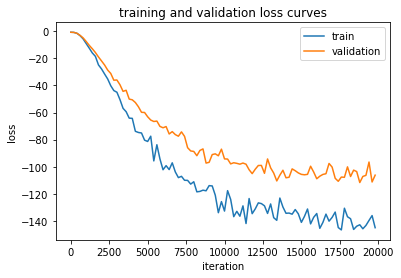

In [ ]:
train_losses = []
val_losses = []
 
for iter in range(ITERATIONS):
    # forward propagation
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(
        train_sparse_edge_index)

    # mini batching
    user_indices, pos_item_indices, neg_item_indices = sample_mini_batch(
        BATCH_SIZE, train_edge_index)
    user_indices, pos_item_indices, neg_item_indices = user_indices.to(
        device), pos_item_indices.to(device), neg_item_indices.to(device)
    users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
    pos_items_emb_final, pos_items_emb_0 = items_emb_final[
        pos_item_indices], items_emb_0[pos_item_indices]
    neg_items_emb_final, neg_items_emb_0 = items_emb_final[
        neg_item_indices], items_emb_0[neg_item_indices]

    # loss computation
    train_loss = bpr_loss(users_emb_final, users_emb_0, pos_items_emb_final,
                          pos_items_emb_0, neg_items_emb_final, neg_items_emb_0, LAMBDA)

    optimizer.zero_grad()
    # doing backpropogation
    train_loss.backward()
    optimizer.step()

# How many training iterations need to be run before doing evaluation -->iters_per_eval
# Just a counter value
    if iter % ITERS_PER_EVAL == 0:
        model.eval()
        val_loss, recall, precision, ndcg = evaluation(
            model, val_edge_index, val_sparse_edge_index, [train_edge_index], K, LAMBDA)
        print(f"[Iteration {iter}/{ITERATIONS}] train_loss: {round(train_loss.item(), 5)}, val_loss: {round(val_loss, 5)}, val_recall@{K}: {round(recall, 5)}, val_precision@{K}: {round(precision, 5)}, val_ndcg@{K}: {round(ndcg, 5)}")
        train_losses.append(train_loss.item())
        val_losses.append(val_loss)
        model.train()
# after ITERS_PER_LR_DECAY of no of iterations the learning rate is reduced., every iters_per_lr_decay steps.
    if iter % ITERS_PER_LR_DECAY == 0 and iter != 0:
        scheduler.step()

iters = [iter * ITERS_PER_EVAL for iter in range(len(train_losses))]
plt.plot(iters, train_losses, label='train')
plt.plot(iters, val_losses, label='validation')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('training and validation loss curves')
plt.legend()
plt.show()



In [ ]:
model.eval()


LightGCN()

In [ ]:
user_embedding = model.users_emb.weight
item_embedding = model.items_emb.weight

In [ ]:
rating = torch.matmul(user_embedding, item_embedding.T)

In [ ]:
rating.detach().numpy()

array([[-9.66247360e+08, -7.65189440e+08, -9.66581248e+08, ...,
        -1.10752602e+09, -2.64044288e+08,  1.20009907e+09],
       [-9.80696512e+08, -7.76631744e+08, -9.81034816e+08, ...,
        -1.12408730e+09, -2.67992704e+08,  1.21804442e+09],
       [-9.68957696e+08, -7.67336256e+08, -9.69292416e+08, ...,
        -1.11063245e+09, -2.64784944e+08,  1.20346496e+09],
       ...,
       [-1.02448595e+09, -8.11310016e+08, -1.02484019e+09, ...,
        -1.17427994e+09, -2.79959232e+08,  1.27243264e+09],
       [-9.31388288e+08, -7.37584064e+08, -9.31710208e+08, ...,
        -1.06756992e+09, -2.54518976e+08,  1.15680371e+09],
       [-1.00109402e+09, -7.92785408e+08, -1.00144006e+09, ...,
        -1.14746752e+09, -2.73566912e+08,  1.24337907e+09]], dtype=float32)

In [ ]:
K=test_edge_index.shape[1]

In [ ]:
# evaluate on test set
model.eval()
# basically evaluates the model
test_edge_index = test_edge_index.to(device)
test_sparse_edge_index = test_sparse_edge_index.to(device)

test_loss, test_recall, test_precision, test_ndcg = evaluation(
            model, test_edge_index, test_sparse_edge_index, [train_edge_index], K, LAMBDA)

print(f"[test_loss: {round(test_loss, 5)}, test_recall@{K}: {round(test_recall, 5)}, test_precision@{K}: {round(test_precision, 5)}, test_ndcg@{K}: {round(test_ndcg, 5)}")

# evaluate on train set
# model.eval()
train_edge_index = train_edge_index.to(device)
train_sparse_edge_index = train_sparse_edge_index.to(device)

train_loss, train_recall, train_precision, train_ndcg = evaluation(
            model, train_edge_index, train_sparse_edge_index, [test_edge_index, val_edge_index], K, LAMBDA)

print(f"[train_loss: {round(train_loss, 5)}, train_recall@{K}: {round(train_recall, 5)}, train_precision@{K}: {round(train_precision, 5)}, train_ndcg@{K}: {round(train_ndcg, 5)}")

# evaluate on validation set
# model.eval()
val_edge_index = val_edge_index.to(device)
val_sparse_edge_index = val_sparse_edge_index.to(device)

val_loss, val_recall, val_precision, val_ndcg = evaluation(
            model, val_edge_index, val_sparse_edge_index, [train_edge_index], K, LAMBDA)

print(f"[val_loss: {round(val_loss, 5)}, val_recall@{K}: {round(val_recall, 5)}, val_precision@{K}: {round(val_precision, 5)}, val_ndcg@{K}: {round(val_ndcg, 5)}")

[test_loss: -100.72652, test_recall@20: 0.02471, test_precision@20: 0.00172, test_ndcg@20: 0.01243
[train_loss: -140.66916, train_recall@20: 0.21182, train_precision@20: 0.13033, train_ndcg@20: 0.20539
[val_loss: -104.12764, val_recall@20: 0.06393, val_precision@20: 0.00411, val_ndcg@20: 0.02089


In [ ]:
# def evaluation1(model, edge_index, sparse_edge_index, k):
#     """Evaluates model loss and metrics including recall, precision, ndcg @ k

#     Args:
#         model (LighGCN): lightgcn model
#         edge_index (torch.Tensor): 2 by N list of edges for split to evaluate
#         sparse_edge_index (sparseTensor): sparse adjacency matrix for split to evaluate
#         exclude_edge_indices ([type]): 2 by N list of edges for split to discount from evaluation
#         k (int): determines the top k items to compute metrics on
#         lambda_val (float): determines lambda for bpr loss

#     Returns:
#         tuple: bpr loss, recall @ k, precision @ k, ndcg @ k
#     """
#     # get embeddings
#     users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(
#         sparse_edge_index)
#     # changed edge_index to sparse_edge_index for edges of negative sampling


#     recall, precision, ndcg = get_metrics1(
#         model, edge_index, k)

#     return recall, precision, ndcg

# def get_metrics1(model, edge_index, k):
#     """Computes the evaluation metrics: recall, precision, and ndcg @ k

#     Args:
#         model (LighGCN): lightgcn model
#         edge_index (torch.Tensor): 2 by N list of edges for split to evaluate
#         exclude_edge_indices ([type]): 2 by N list of edges for split to discount from evaluation
#         k (int): determines the top k items to compute metrics on

#     Returns:
#         tuple: recall @ k, precision @ k, ndcg @ k
#     """
#     user_embedding = model.users_emb.weight
#     item_embedding = model.items_emb.weight

#     # get ratings between every user and item - shape is num users x num movies
#     rating = torch.matmul(user_embedding, item_embedding.T)



#     # get the top k recommended items for each user
#     _, top_K_items = torch.topk(rating, k=k)

#     # get all unique users in evaluated split
#     users = edge_index[0].unique()

#     test_user_pos_items = get_user_positive_items1(edge_index)
#     # test_user_pos_items is a list of user with positive items
#     # convert test user pos items dictionary into a list
#     test_user_pos_items_list = [
#         test_user_pos_items[user.item()] for user in users]

#     # determine the correctness of topk predictions
#     r = []
#     for user in users:
#         ground_truth_items = test_user_pos_items[user.item()]
#         #ground_truth has all the items that are positive for the user in all the users
#         label = list(map(lambda x: x in ground_truth_items, top_K_items[user]))
#         r.append(label)
#     r = torch.Tensor(np.array(r).astype('float'))
#     # r has only the users for the top_k items that also present in the positives items for all users.
#     recall, precision = RecallPrecision_ATk(test_user_pos_items_list, r, k)
#     ndcg = NDCGatK_r(test_user_pos_items_list, r, k)

#     return recall, precision, ndcg

# def get_user_positive_items1(edge_index):
#     """Generates dictionary of positive items for each user

#     Args:
#         edge_index (torch.Tensor): 2 by N list of edges

#     Returns:
#         dict: dictionary of positive items for each user
#     """
#     # basically returing all the items for that user which are present in the edge index (postive items)
#     # if the items are not present in the edge index for that user --> considered negative item
#     user_pos_items = {}
#     for i in range(edge_index.shape[1]):
#         user = edge_index[0][i].item()
#         item = edge_index[1][i].item()
#         # if user not in user_pos_items:
#         user_pos_items[user] = []
#         user_pos_items[user].append(item)
#         # so user_pos_items is list of the user with the respective positive items
#     return user_pos_items


In [ ]:
# # evaluate on test set
# model.eval()
# # basically evaluates the model
# test_edge_index = test_edge_index.to(device)
# test_sparse_edge_index = test_sparse_edge_index.to(device)

# test_recall, test_precision, test_ndcg = evaluation1(
#             model, test_edge_index, test_sparse_edge_index,K)
# #[train_edge_index, val_edge_index]
# print(f" test_recall@{K}: {round(test_recall, 5)}, test_precision@{K}: {round(test_precision, 5)}, test_ndcg@{K}: {round(test_ndcg, 5)}")





In [ ]:
# model.eval()
# # basically evaluates the model
# test_edge_index = test_edge_index.to(device)
# test_sparse_edge_index = test_sparse_edge_index.to(device)

# test_recall, test_precision, test_ndcg = evaluation1(
#             model, test_edge_index, test_sparse_edge_index,K)
# #[train_edge_index, val_edge_index]
# print(f" test_recall@{K}: {round(test_recall, 5)}, test_precision@{K}: {round(test_precision, 5)}, test_ndcg@{K}: {round(test_ndcg, 5)}")

In [ ]:
# model.eval()
# val_edge_index = val_edge_index.to(device)
# val_sparse_edge_index = val_sparse_edge_index.to(device)

# val_recall, val_precision, val_ndcg = evaluation1(
#             model, val_edge_index, val_sparse_edge_index, K)
# print(f" val_recall@{K}: {round(val_recall, 5)}, val_precision@{K}: {round(val_precision, 5)}, val_ndcg@{K}: {round(val_ndcg, 5)}")


In [ ]:
"""# Make New Recommendatios for a Given User"""

model.eval()
df = pd.read_csv(place_path)
Place_Name = pd.Series(df.Place_Name.values,index=df.Place_Id).to_dict()
# business_categories = pd.Series(df.business_categories.values,index=df.business_id).to_dict()

user_pos_items = get_user_positive_items(edge_index)

def make_predictions(user_id,num_recs):
    user = user_mapping[user_id]
    e_u = model.users_emb.weight[user]
    scores = model.items_emb.weight @ e_u

    values, indices = torch.topk(scores, k=len(user_pos_items[user])+num_recs)
    print("indic",indices)
    print("k",len(user_pos_items[user]))

    places = [index.cpu().item() for index in indices if index in user_pos_items[user]][:num_recs]
    
    print(places)
    place_ids = [list(place_mapping.keys())[list(place_mapping.values()).index(place)] for place in places]
    print("length is",len(place_ids))
    
    place_name = [Place_Name[id] for id in place_ids]
    print(place_name)
    # categories = [business_categories[id] for id in review_ids]

    print(f"Here are some places that user {user_id} rated highly")
    
    for i in range(len(places)):
        # print(f"city: {city[i]}, categories: {categories[i]} ")
        print(f"place: {place_name[i]}")
    print()

    places = [index.cpu().item() for index in indices if index not in user_pos_items[user]][:num_recs]
    place_ids = [list(place_mapping.keys())[list(place_mapping.values()).index(place)] for place in places]
    place_name = [Place_Name[id] for id in place_ids]
    # categories = [business_categories[id] for id in review_ids]

    print(f"Here are some suggested places for user {user_id}")
    for i in range(num_recs):
        # print(f"title: {city[i]}, genres: {categories[i]} ")
        print(f"place: {place_name[i]}")
USER_ID = 2
NUM_RECS = 5

make_predictions(USER_ID,NUM_RECS)